0       2023-01
1       2023-01
2       2023-01
3       2023-01
4       2023-01
         ...   
7305    2024-12
7306    2024-12
7307    2024-12
7308    2024-12
7309    2024-12
Name: month_And_day, Length: 7310, dtype: object
Index(['date', 'product_name', 'category', 'units_sold', 'unit_price',
       'market_trend_index', 'is_holiday', 'flu_alert_level', 'economic_index',
       'month_day', 'season', 'month_And_day'],
      dtype='object')
0       01-01
1       01-01
2       01-01
3       01-01
4       01-01
        ...  
7305    12-31
7306    12-31
7307    12-31
7308    12-31
7309    12-31
Name: month_day, Length: 7310, dtype: object
30     26736.0
31     26763.0
32     27462.0
33     27137.0
34     26995.0
        ...   
125    29277.0
126    29298.0
127    28959.0
128    28850.0
129    29479.0
Name: roll_sum_30, Length: 100, dtype: float64
Mapping: {'Amoxicillin 500mg': np.int64(0), 'Atorvastatin 20mg': np.int64(1), 'Insulin Glargine 10ml': np.int64(2), 'Surgical Gloves Box': np.i

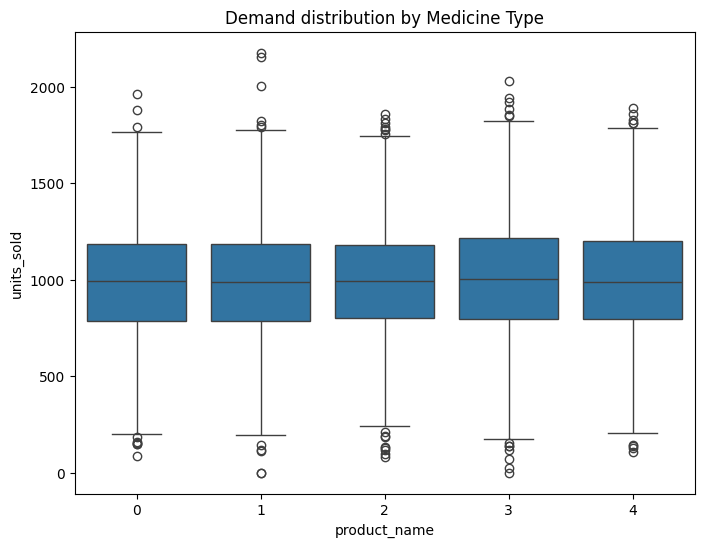

In [81]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

data_1=pd.read_csv('McKesson_Large_Demand_Forecasting_Dataset.csv')
data_2=pd.read_csv('daily_dataset_2023.csv')
data_1.drop(columns=['product_id','region'], inplace=True)
# data_1['date']=pd.to_datetime(data_1['date'])
# data_2['date']=pd.to_datetime(data_1['date'])
data_1['month_day'] = data_1['date'].str[5:10]
data_2['month_day'] = data_2['date'].str[5:10]
merged_df = pd.merge(data_1, data_2[['month_day', 'season']], 
                     on='month_day', 
                     how='left')
merged_df['month_And_day'] = merged_df['date'].str[0:7]
print(merged_df['month_And_day'])

merged_df['date']=pd.to_datetime(merged_df['date'])
print(merged_df.columns)
print(merged_df['month_day'])
merged_df['month_day']=merged_df['month_day'].str[3:5].astype(int)
merged_df['day_of_week'] = merged_df['date'].dt.weekday        # 0=Monday, 6=Sunday
merged_df['week_of_month'] = merged_df['date'].apply(lambda d: (d.day-1)//7 + 1)
merged_df['month'] = merged_df['date'].dt.month
merged_df['is_weekend'] = (merged_df['day_of_week'] >= 5).astype(int)
merged_df['lag_1'] = merged_df['units_sold'].shift(1)   
merged_df['lag_7'] = merged_df['units_sold'].shift(7)
merged_df['roll_mean_7'] = merged_df['units_sold'].shift(1).rolling(7).mean()
merged_df['roll_std_7']  = merged_df['units_sold'].shift(1).rolling(7).std()
merged_df['roll_sum_30'] = merged_df['units_sold'].shift(1).rolling(30).sum()
merged_df.dropna(inplace=True)
# missing_count = merged_df['units_sold'].isnull().sum()
# print(missing_count)
print(merged_df['roll_sum_30'].head(100))
merged_df['medicine_season'] = merged_df['product_name'].astype(str) + "_" + merged_df['season'].astype(str)
merged_df['medicine_flu'] = merged_df['product_name'].astype(str) + "_" + merged_df['flu_alert_level'].astype(str)
for col in ['product_name','category','flu_alert_level','season','medicine_season','medicine_flu']:
    if col in merged_df.columns:
        le = LabelEncoder()
        merged_df[col] = le.fit_transform(merged_df[col].astype(str))
        print("Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

print(merged_df['month'].tail(100))
print(merged_df['roll_sum_30'].head(30))
print(merged_df['week_of_month'].tail(100))



# Encode them




# le_1 = LabelEncoder()
# le_2 = LabelEncoder()
# merged_df['medicine_type_encoded'] = le_1.fit_transform(merged_df['product_name'])
# merged_df['category_encoded'] = le_2.fit_transform(merged_df['category'])

# merged_df.drop(columns=['date'], inplace=True)
print(merged_df.columns)
# print(merged_df['roll_mean_7'].head(10))
# print(merged_df['medicine_type_encoded'])
# print("Mapping:", dict(zip(le_1.classes_, le_1.transform(le_1.classes_))))
# print(merged_df['medicine_type_encoded'])
# print("Mapping:", dict(zip(le_2.classes_, le_2.transform(le_2.classes_))))
plt.figure(figsize=(8,6))
sns.boxplot(x='product_name', y='units_sold', data=merged_df)
plt.title("Demand distribution by Medicine Type")
plt.show()



In [2]:
# merged_df = merged_df.sort_values('date').reset_index(drop=True)
def inv_boxcox(y_transformed, lambda_value):
    if lambda_value == 0:
        return np.exp(y_transformed)
    else:
        return (y_transformed * lambda_value + 1) ** (1 / lambda_value)

import prophet
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from scipy import stats

# new_dataset_Amoxicillin_500mg = merged_df[merged_df['product_name'] == 'Amoxicillin_500mg']
selected_columns=['date', 'product_name', 'category', 'units_sold', 'unit_price',
       'market_trend_index', 'is_holiday', 'flu_alert_level', 'economic_index',
       'month_day', 'season', 'day_of_week', 'week_of_month', 'month',
       'is_weekend', 'lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7',
       'roll_sum_30','medicine_season','medicine_flu','month_And_day'];

my_dict = {'Amoxicillin 500mg': 0, "Atorvastatin 20mg": 1, "Insulin Glargine 10ml": 2,"Surgical Gloves Box":3,"Surgical Masks Box":4}
for key, value in my_dict.items():
    print(f"{key}: {value}")
    new_dataset = merged_df.loc[merged_df['product_name'] == value, selected_columns]
    # print(new_dataset[['date','month_And_day', 'week_of_month','week_of_month','units_sold']].head(20))
    # print(new_dataset.shape[0])
    # print(new_dataset.head(10))
    average_df = new_dataset.groupby(['month_And_day', 'week_of_month']).mean()
    result_df = average_df.reset_index()
    # print(result_df.head(20))
    # print(result_df.shape[0])
    # print(new_dataset)
    # df['demand_log'] = np.log1p(df['demand'])
    cutoff = int(len(result_df) * 0.8)
    train = result_df.iloc[:cutoff]
    test  = result_df.iloc[cutoff:]
   


    features = [ 'category'
       , 'flu_alert_level'
       , 'season',  'week_of_month', 'month',
        'lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7',
       'roll_sum_30']
    X_train, y_train = train[features], train['units_sold']
    X_test,  y_test  = test[features],  test['units_sold']
    corr_matrix = X_train.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
    
    print("columns to drop due to high correlation:")
    print(to_drop)
    # X_train_selected = X_train.drop(columns=to_drop)
    y_train_transformed, lambda_value = stats.boxcox(y_train)


    # Plot the heatmap
    if value == 0:
      plt.figure(figsize=(12, 8))
      sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
      plt.show()
    model = XGBRegressor(
      n_estimators=40,
      learning_rate=0.03,
      max_depth=3,
      min_child_weight=15,
      subsample=0.8,
      colsample_bytree=0.8,
      reg_lambda=0.5,
      alpha=1,
      random_state=42
      )
    rf_model = RandomForestRegressor(
    n_estimators=175,      # number of trees
    max_depth=10,          # limit depth
    random_state=42,
    n_jobs=-1              # use all cores
    )


    model.fit(X_train, y_train_transformed)
    selector = SelectFromModel(model, threshold="mean", max_features=10)
    X_selected = selector.transform(X_train)

    selected_features = X_train.columns[selector.get_support()]
    print(f"Selected features: {selected_features}")
    pred = model.predict(X_test)
    y_pred = inv_boxcox(pred, lambda_value)
    y_pred_xg = y_pred.copy()
    # print(y_pred)

    # print(pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print("XGBoost Model "+f"MAE: {mae:.2f} | RMSE: {rmse:.2f}" + " | MAPE:", mape)

    plt.figure(figsize=(10,4))
    plt.plot(test['date'], y_test - y_pred, label='Residuals_XGBoost')
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals over time")
    plt.legend()
    plt.show()

    

    rf_model.fit(X_train, y_train_transformed)
    pred = rf_model.predict(X_test)
    y_pred = inv_boxcox(pred, lambda_value)
    y_pred_rf= y_pred.copy()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print("Random Forest Model "+f"MAE: {mae:.2f} | RMSE: {rmse:.2f}" + " | MAPE:", mape)

    plt.figure(figsize=(10,4))
    plt.plot(test['date'], y_test - y_pred, label='Residuals_RandomForest')
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals over time")
    plt.legend()
    plt.show()

    plt.subplot(1,2,1)
    plt.scatter(y_test, y_test - y_pred_xg, alpha=0.6, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Actual Demand")
    plt.ylabel("Residuals (y_test - y_pred)")
    plt.title("Residuals: Random Forest")
# XGBoost residual plot
    plt.subplot(1,2,2)
    plt.scatter(y_test, y_test - y_pred_rf, alpha=0.6, color='green')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Actual Demand")
    plt.ylabel("Residuals (y_test - y_pred)")
    plt.title("Residuals: XGBoost")
    plt.tight_layout()
    plt.show()

    
    plt.figure(figsize=(12,6))

# Plot residuals as line graphs
    plt.plot(np.arange(len(y_test)), y_test - y_pred_rf, label='Random Forest Residuals', color='blue')
    plt.plot(np.arange(len(y_test)), y_test - y_pred_xg, label='XGBoost Residuals', color='green')
# Baseline line at zero
    plt.axhline(0, color='red', linestyle='--')

    plt.xlabel("Test Sample Index")
    plt.ylabel("Residuals (y_test - y_pred)")
    plt.title("Residuals Comparison: Random Forest vs XGBoost")
    plt.legend()
    plt.show()

    tscv = TimeSeriesSplit(n_splits=5)

    mae_scores = []
    rmse_scores = []
    mape_scores = []
    print("Time Series Cross-Validation Results:")
    x = result_df[['category',
       'market_trend_index', 'flu_alert_level', 'economic_index'
       , 'season',  'week_of_month', 'month',
        'lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7',
       'roll_sum_30']]
    y = result_df['units_sold']
    for fold, (train_idx, test_idx) in enumerate(tscv.split(x)):
      X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
      y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
      # Example: XGBoost model
      rf_model = RandomForestRegressor(
       n_estimators=175,      # number of trees
       max_depth=10,          # limit depth
       random_state=42,
       n_jobs=-1              # use all cores
       )
      rf_model.fit(X_train, y_train)
      y_pred = rf_model.predict(X_test)
      mae = mean_absolute_error(y_test, y_pred)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
      mae_scores.append(mae)
      rmse_scores.append(rmse)
      mape_scores.append(mape)
    
      print(f"Fold {fold+1} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    print("Average MAE:", np.mean(mae_scores))
    print("Average RMSE:", np.mean(rmse_scores))
    print("Average MAPE:", np.mean(mape_scores))


prophet_data = new_dataset[['date', 'units_sold', 'flu_alert_level', 'category', 'season', 'lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7', 'roll_sum_30']].copy()
df_prophet = prophet_data.rename(columns={'date': 'ds', 'units_sold': 'y'})
model = Prophet(
    yearly_seasonality=True,   # captures yearly medicine demand cycles
    weekly_seasonality=True,   # captures weekly patterns
    daily_seasonality=False    # usually not needed unless intra-day demand
)
train = df_prophet.iloc[:-80]   # training set
test  = df_prophet.iloc[-80:]
model.add_regressor('flu_alert_level')
model.add_regressor('category')
model.add_regressor('season')
model.add_regressor('lag_1')
model.add_regressor('lag_7')
model.add_regressor('roll_mean_7')
model.add_regressor('roll_std_7')
model.add_regressor('roll_sum_30')
model.fit(train)
forecast = model.predict(test[['ds', 'flu_alert_level', 'category', 'season', 'lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7', 'roll_sum_30']])
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
y_pred = forecast[['ds','yhat']]   # predicted demand
y_true = test[['ds','y']]
mae = mean_absolute_error(y_true['y'], y_pred['yhat'])
rmse = np.sqrt(mean_squared_error(y_true['y'], y_pred['yhat']))

print("MAE:", mae, "RMSE:", rmse)

# future = model.make_future_dataframe(periods=30)
# target_value = 0
# selected_columns = ['flu_alert_level', 'product_name','units_sold']
# new_dataset = merged_df.loc[merged_df['product_name'] == target_value, selected_columns]
# print(new_dataset)

# df_grouped = merged_df.groupby(['product_name','date']).agg({'units_sold':'sum'}).reset_index()
plt.figure(figsize=(12,6))
sns.scatterplot(data=new_dataset, x='flu_alert_level', y='units_sold', hue='product_name')
plt.title("Demand spikes per medicine type over time")
plt.show()







ModuleNotFoundError: No module named 'prophet'